elapsed :  0.3655586242675781


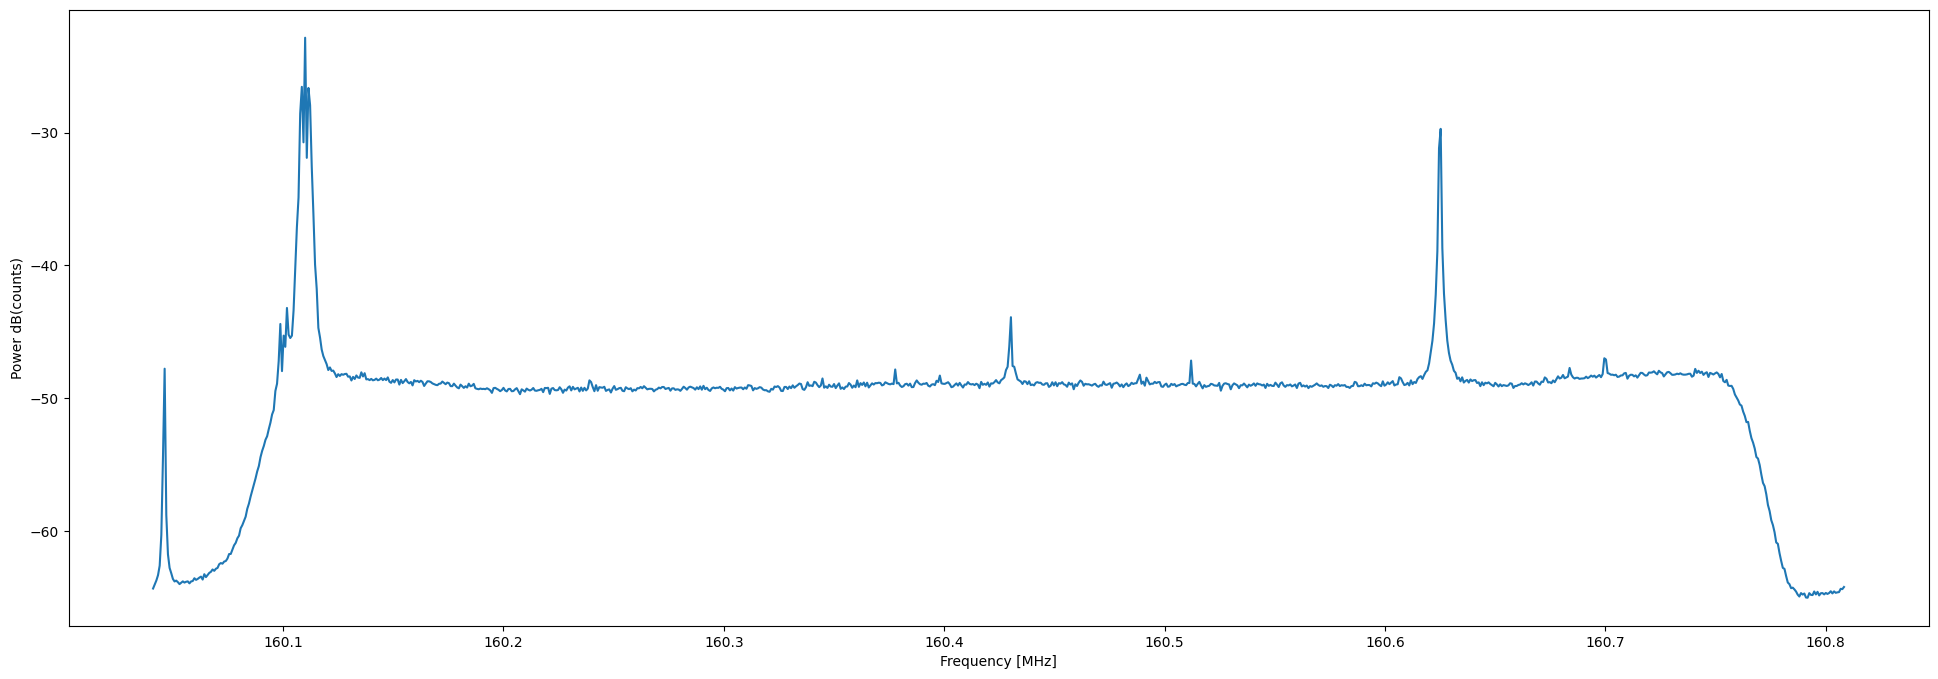

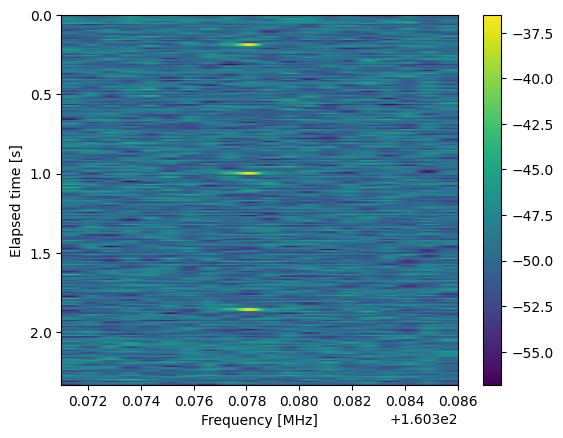

<Figure size 2400x0 with 0 Axes>

In [15]:
import numpy as np
import pylab as plt
import scipy
import time

def db(x):
    return 10*np.log10(x)

#d = np.fromfile(open("test_multiple_v2.fc32"), dtype=np.complex64)
#d = np.fromfile(open("../data/six_channels_768000.fc32"), dtype=np.complex64)
#d = np.fromfile(open("neighbouring_ch_912000_3.fc32"), dtype=np.complex64)
#d = np.fromfile(open("../data/10s_160377933.fc32"), dtype=np.complex64)
#d = np.fromfile(open("../data/test_multiple_8_ch_v1.fc32"), dtype=np.complex64)
d = np.fromfile(open("../data/res_to_mtn_ct.fc32"), dtype=np.complex64)
d = d[157_952_000:159_744_000]

f0 = 160.425e6    # Center frequency
Fs = 768e3        # Sampling rate
#Fs = 912e3        # Sampling rate
N_fft = 1024      # Number of FFT channels

# Generate array of channel frequencies
f = (np.fft.fftshift(np.fft.fftfreq(N_fft, 1/Fs)) + f0) / 1e6

start = time.time()
# Time tag each sample
t = np.arange(len(d)) / Fs

# Reshape so we can do an FFT over an axis
d_fft = d.reshape((-1, N_fft))
D = np.fft.fftshift(np.fft.fft(d_fft, axis=1), axes=(1,))

# Time tag each sample coming from a channel
T = np.arange(len(D)) / Fs * N_fft

# Now convert into power spectral density
# 1. Reshape to (N_timestep, N_int_per_timestep, N_fft)
# 2. Square
# 3. Sum over N_int_per_timestep axis
N_time_PSD = 250
PSD = (np.abs(D.reshape((N_time_PSD, -1, N_fft)))**2).mean(axis=1)

# Create overall spectrum
spec = PSD.mean(axis=0)

# Find peaks (note: I hand-tuned prominence)
p = scipy.signal.find_peaks(spec, prominence=0.1)[0]

#**********************

# Extract the time series for each channel identified
t_kiwis = []
for idx in p:
    t_kiwis.append(D[:, idx])

# And extract the carrier frequencies
f_kiwis = f[p]
end = time.time()
print(f"elapsed :  {end - start }")

# AVERAGED PSD
plt.figure(figsize=(24,8))
plt.plot(f, db(spec))
plt.scatter(f[p], db(spec)[p], marker='x', color='#cc0000')
plt.xlabel("Frequency [MHz]")
plt.ylabel("Power dB(counts)")
plt.show()

# SPECTROGRAM
plt.figure()
plt.imshow(db(PSD[:, 440:460]), aspect='auto', extent=(f[440], f[460], T[-1], T[0]))
plt.xlabel("Frequency [MHz]")
plt.ylabel("Elapsed time [s]")
plt.colorbar()
plt.show()

# CHANNEL PLOTS
threshold = 2.2
plt.figure(figsize=(24, len(p) * 2))
for ii, tk in enumerate(t_kiwis):
    plt.subplot(len(p), 1, ii+1)
    plt.plot(T, np.abs(tk))
    plt.title(f"Kiwi {ii+1}, ({f_kiwis[ii]:.3f} MHz)")
    plt.xlabel("Time [s]")

    low_samples = np.abs(tk) < threshold
    high_samples = np.abs(tk) >= threshold
    rising_edge_idx = np.nonzero(low_samples[:-1] & np.roll(high_samples, -1)[:-1])[0]
    falling_edge_idx = np.nonzero(high_samples[:-1] & np.roll(low_samples, -1)[:-1])[0]
    
    print(f"{f_kiwis[ii]:.3f} MHz {60 / (np.diff(rising_edge_idx)/750 )}\n " )
    
plt.tight_layout()
